In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import modelos as md

In [2]:
dataframe_treino = pd.read_csv('train_reduzido_1_5.csv', sep=';')
dataframe_teste = pd.read_csv('test_reduzido_1_5.csv', sep=';')

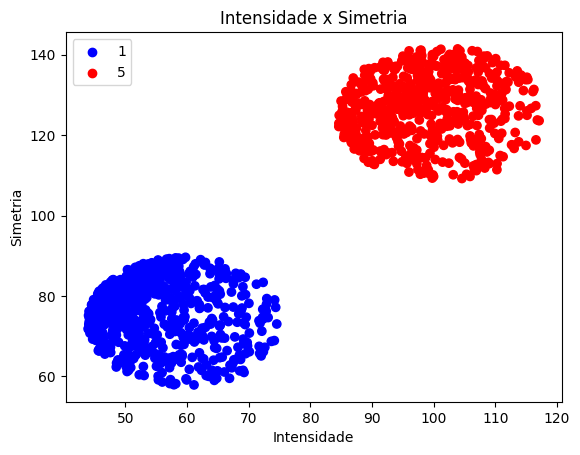

In [3]:
# Plotando o grafico intensidade x simetria do conjunto de treino
cores = {1: 'blue', 5: 'red'}
plt.scatter(dataframe_treino['intensidade'], dataframe_treino['simetria'], c=dataframe_treino['label'].map(cores))
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
for label, cor in cores.items():
    plt.scatter([], [], color=cor, label=label)
plt.legend()
plt.show()


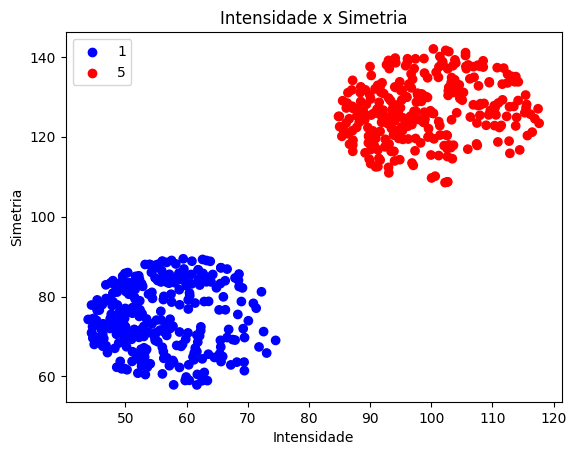

In [4]:
# Plotando o grafico intensidade x simetria do conjunto de teste
cores = {1: 'blue', 5: 'red'}

plt.scatter(dataframe_teste['intensidade'], dataframe_teste['simetria'], c=dataframe_teste['label'].map(cores))
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
for label, cor in cores.items():
    plt.scatter([], [], color=cor, label=label)
plt.legend()
plt.show()

# Regressão Logística

### Tratamento dos dados

In [5]:
# Funçao para transformar os dados em uma normal 0,1
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

# Obtendo os valores de treino e teste
X = dataframe_treino[['intensidade', 'simetria']].values
X_teste = dataframe_teste[['intensidade', 'simetria']].values
Y = dataframe_treino['label'].values
y_teste = dataframe_teste['label'].values

# Transformando os dados e alterando os valores de label para 1 e -1
X = padronizar_normal(X)
X_teste = padronizar_normal(X_teste)
Y[Y == 1] = 1
Y[Y == 5] = -1
y_teste[y_teste == 1] = 1
y_teste[y_teste == 5] = -1

# Adicionando uma coluna de 1s
X = np.c_[np.ones(len(X)), X]
X_teste = np.c_[np.ones(len(X_teste)), X_teste]

### Criando a classe RegressaoLogistica

In [6]:
class RegressaoLogistica():
    def __init__(self, eta = 0.000001, max_iter = 1000):
        self.eta = eta
        self.max_iteracoes = max_iter
    # Função que vai atribuir a cada amostra uma probabilidade de ser 1 ou 5 (1 ou -1)
    def probabilidades(self,w, X):
        z = np.matmul(w, X) # Esse aqui é o X.T para a operaçao ser possivel. Tambem pode ser feito com np.dot(w, X)
        probabilidades_amostrais = 1/(1+np.exp(-z))
        return probabilidades_amostrais
    
    # Funçção que vai atribuir a cada amostra uma classe de acordo com sua probabilidade
    def atribuicao_de_classes(self,probabilidades_amostrais):
        classes_amostrais_previstas = np.zeros(len(probabilidades_amostrais))
        classes_amostrais_previstas[np.where(probabilidades_amostrais<0.5)] = -1
        classes_amostrais_previstas[np.where(probabilidades_amostrais>=0.5)] = 1
        return classes_amostrais_previstas
    
    # Função que vai calcular a acuracia do modelo
    def calculate_accuracy(self,classes_amostrais_previstas, y):
        accuracy = (sum(classes_amostrais_previstas==y)/len(y))*100
        return accuracy


    def fit(self, X, Y):
        y = Y
        accuracies = []
        w = np.zeros(X.shape[0])
        m = len(y)
        
        for i in range(self.max_iteracoes):
            probabilidades_amostrais = self.probabilidades(w, X)
            classes_amostrais_previstas = self.atribuicao_de_classes(probabilidades_amostrais)
            accuracies.append(self.calculate_accuracy(classes_amostrais_previstas, y))
            erros = probabilidades_amostrais - y
            gradiente = (1/m)*np.matmul(X,erros)
            w = w - (self.eta*gradiente)
        
        self.classes_amostrais_previstas = classes_amostrais_previstas
        self.w = w
        self.accuracy = accuracies[-1]

        return w, accuracies[-1], classes_amostrais_previstas

    def get_w(self):
        return self.w
    
    

### Criando o objeto e treinando o modelo de Regressão Logistica

Acuracia:  100.0
[[576   0]
 [  0 608]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       576
           5       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184



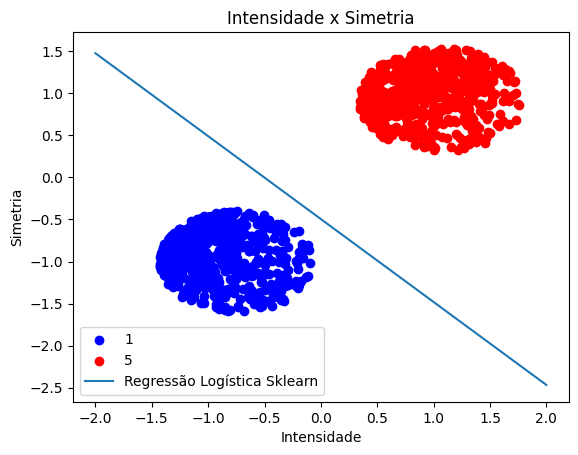

In [22]:
modelo = md.RegressaoLogistica()
w, acuracia, y_pred_treino = modelo.fit(X.T, Y) # Passo o X.transpose() para que a multiplicação de matrizes seja possível
print('Acuracia: ', acuracia)

#Criando a matriz de confusão
matriz_de_confusao_treino = confusion_matrix(Y, y_pred_treino)
print(matriz_de_confusao_treino)

#Printando o relatório de classificação
print(classification_report(Y, y_pred_treino, target_names=['1', '5']))

# Voltando os valores de y_pred_treino para 1 e 5
y_pred_treino[y_pred_treino == 1] = 1
y_pred_treino[y_pred_treino == -1] = 5

# Criando a reta para plotar o gráfico
x = np.linspace(-2, 2, 100)
y_plot = (-w[0] - w[1]*x) / w[2]
# printando as bolinhas vermelhas e azuis, se a classe for 1 (numero 1), plota azul, se for -1, plota vermelho
plt.scatter(X[y_pred_treino == 1, 1], X[y_pred_treino == 1, 2], color='blue', marker='o', label='1')
plt.scatter(X[y_pred_treino == 5, 1], X[y_pred_treino == 5, 2], color='red', marker='o', label='5')
plt.plot(x, y_plot, label='Regressão Logística Sklearn')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
plt.legend()
plt.show()

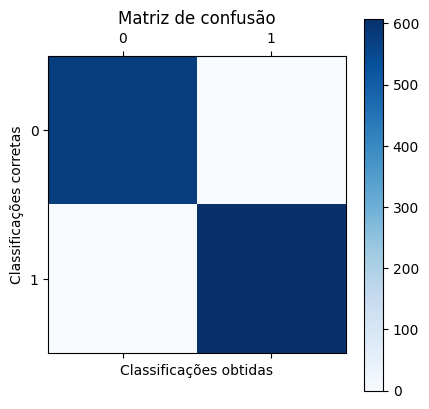

In [8]:
plt.matshow(matriz_de_confusao_treino, cmap='Blues')
plt.title('Matriz de confusão')
plt.colorbar()
plt.ylabel("Classificações corretas")
plt.xlabel("Classificações obtidas")
plt.show()

### Utilizando o w encontrado no treino para o teste (generalização)

Acuracia:  100.0
[[291   0]
 [  0 292]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       291
           5       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



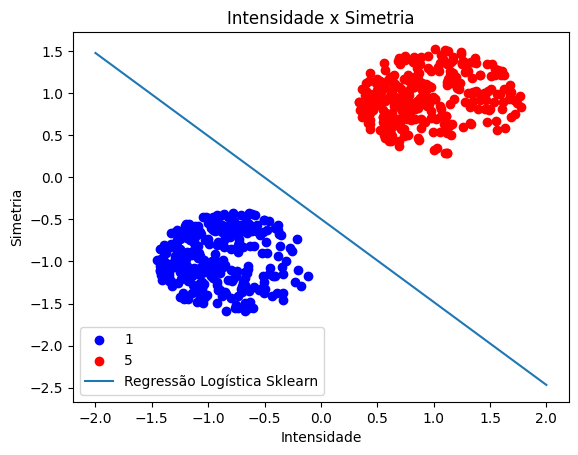

In [9]:
probabilidades = modelo.probabilidades(w, X_teste.T) # Passo o X.transpose() para que a multiplicação de matrizes seja possível e o w que foi obtido no treino
y_pred_test = modelo.atribuicao_de_classes(probabilidades)
print('Acuracia: ', modelo.calculate_accuracy(y_pred_test, y_teste))

#Printando a matriz de confusao
matriz_de_confusao_teste = confusion_matrix(y_teste, y_pred_test)
print(matriz_de_confusao_teste)
#Printando o relatório de classificação
print(classification_report(y_teste, y_pred_test, target_names=['1', '5']))

# Voltando os valores de y_pred_test para 1 e 5
y_pred_test[y_pred_test == 1] = 1
y_pred_test[y_pred_test == -1] = 5

x = np.linspace(-2, 2, 100)
y_plot = (-w[0] - w[1]*x) / w[2]
# printando as bolinhas vermelhas e azuis, se a classe for 1 (numero 1), plota azul, se for -1, plota vermelho
plt.scatter(X_teste[y_pred_test == 1, 1], X_teste[y_pred_test == 1, 2], color='blue', marker='o', label='1') # primeiro argumento é a intensidade, segundo é a simetria 
plt.scatter(X_teste[y_pred_test == 5, 1], X_teste[y_pred_test == 5, 2], color='red', marker='o', label='5')
plt.plot(x, y_plot, label='Regressão Logística Sklearn')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
plt.legend()
plt.show()

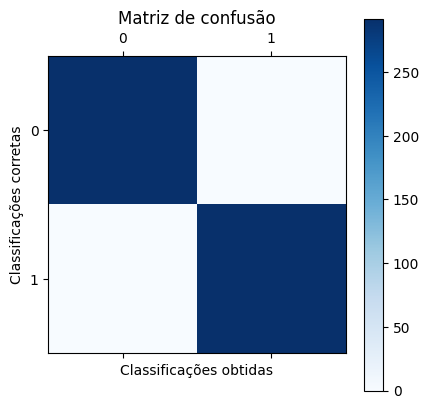

In [10]:
plt.matshow(matriz_de_confusao_teste, cmap='Blues')
plt.title('Matriz de confusão')
plt.colorbar()
plt.ylabel("Classificações corretas")
plt.xlabel("Classificações obtidas")
plt.show()

### Criando o objeto e treinando o modelo de Regressão Linear

In [19]:
modelo = md.RegressaoLinear()
w, acuracia, y_pred_treino = modelo.fit(X.T, Y) # Passo o X.transpose() para que a multiplicação de matrizes seja possível
print('Acuracia: ', acuracia)

#Criando a matriz de confusão
matriz_de_confusao_treino = confusion_matrix(Y, y_pred_treino)
print(matriz_de_confusao_treino)

#Printando o relatório de classificação
print(classification_report(Y, y_pred_treino, target_names=['1', '5']))

# Voltando os valores de y_pred_treino para 1 e 5
y_pred_treino[y_pred_treino == 1] = 1
y_pred_treino[y_pred_treino == -1] = 5

# Criando a reta para plotar o gráfico
x = np.linspace(-2, 2, 100)
y_plot = (-w[0] - w[1]*x) / w[2]
# printando as bolinhas vermelhas e azuis, se a classe for 1 (numero 1), plota azul, se for -1, plota vermelho
plt.scatter(X[y_pred_treino == 1, 1], X[y_pred_treino == 1, 2], color='blue', marker='o', label='1')
plt.scatter(X[y_pred_treino == 5, 1], X[y_pred_treino == 5, 2], color='red', marker='o', label='5')
plt.plot(x, y_plot, label='Regressão Logística Sklearn')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
plt.legend()
plt.show()

ValueError: shapes (1184,3) and (1184,) not aligned: 3 (dim 1) != 1184 (dim 0)